Note: this has much code that was highly inspired or directly taken from Chapter 4 of Fastbook, Fast.ai's machine learning book. In Ch 4, they create a binary MNIST classifier, distinguishing between 3's and 7's. This implementation is a multi-class classifier - a single model that can predict all 10 digits in the MNIST dataset.

# Setup

In [5]:
!pip install -Uqq fastai fastbook

In [6]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys') # set the default color palette to greys (0 is white, 255 is black)

# Data Processing and Exploration

In [7]:
# get MNIST dataset
path = untar_data(URLs.MNIST)
#Path.BASE_PATH = path
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [8]:
# see all the folders (all numbers)
(path/'training').ls().sorted()

(#10) [Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/9')]

In [9]:
# get one image and view it
first_zero_path = (path/'training/0').ls()[0]
first_zero = Image.open(first_zero_path)
first_zero

In [10]:
# convert it to tensor
tensor(first_zero)

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  45, 178, 253, 242, 166, 216,  41,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 120, 225, 252, 252, 253, 2

In [11]:
train_images = []
valid_images = []

# convert all training and test data to tensors
for i in range(10):
  paths = (path/f'training/{i}').ls()
  train_images.append(torch.stack([tensor(Image.open(x)) for x in paths]).float()/255) #create image tensor and scale pixel values between 0 and 1

  paths = (path/f'testing/{i}').ls()
  valid_images.append(torch.stack([tensor(Image.open(x)) for x in paths]).float()/255)

<Axes: >

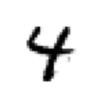

In [12]:
# sample one of the 4s
show_image(train_images[4][20])

In [13]:
# check out the shape of one of the 3d tensors (rank 3)
train_images[0].shape

# notice there are 5923 training instances (images), each 28 pixels by 28 pixels

torch.Size([5923, 28, 28])

# Calculating Loss

**Getting the "ideal" digit for each number (average)**

Couldn't we simply get the pixel-wise average of each number's training set, and then see how far away our test data is from that average by getting the average delta of each pixel? We could calculate the L1 or L2 norm (MAE or RMSE) of that instance from each averaged digit - the lowest error result would be our prediction.

Let's continue with this as our evaluation method for now, until we introduce a better method (gradient descent) later.

<Axes: >

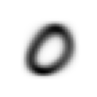

In [14]:
# Get the pixel-wise average of the 0s to get the "ideal" 0
ideal_zero = train_images[0].mean(0)
show_image(ideal_zero)

MAE: 0.14024855196475983
RMSE: 0.37449774146080017


<Axes: >

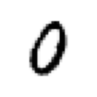

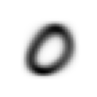

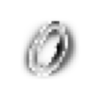

In [15]:
# Get the difference from one of our testing instances, just as an example
delta_tensor = (valid_images[0][20] - ideal_zero).abs()

# calculate the mean absolute error (MAE - just the average of our delta tensor)
mae = delta_tensor.mean()
print(f'MAE: {mae}')

# we can also determine the error with root mean squared error (RMSE), where
# larger differences are penalized more
squared_error_delta_tensor = ((valid_images[0][20] - ideal_zero)**2)
rmse = delta_tensor.mean().sqrt()
print(f'RMSE: {rmse}')

#Random image of 0 from testing set
show_image(valid_images[0][20])

#ideal 0
show_image(ideal_zero)

#delta tensor
show_image(delta_tensor)

In [16]:
# Let's use this method and see how accurate the predictions across our whole test set are

def create_ideal_nums(X):
  # get all ideal nums

  ideal_nums = []
  for i in range(10):
    ideal_nums.append(X[i].mean(0)) # perform pixel-wise average across all training instances

  return ideal_nums


def calculate_class_mae(X, ideal_nums):
  mean_absolute_errors = []

  for i in range(len(X)):
    mean_absolute_errors.append((X[i] - ideal_nums[i]).abs().mean()) #broadcast ideal num and get difference between all test instances, take absolute value, and get average

  return mean_absolute_errors


def calculate_class_rmse(X, ideal_nums):
  root_mean_squared_errors = []

  for i in range(len(X)):
    root_mean_squared_errors.append(((X[i] - ideal_nums[i])**2).mean().sqrt()) #similar, but do RMSE instead

  return root_mean_squared_errors


ideal_nums = create_ideal_nums(train_images)
print(calculate_class_mae(valid_images, ideal_nums))
print(calculate_class_rmse(valid_images, ideal_nums))

[tensor(0.1436), tensor(0.0664), tensor(0.1453), tensor(0.1296), tensor(0.1197), tensor(0.1378), tensor(0.1273), tensor(0.1088), tensor(0.1326), tensor(0.1118)]
[tensor(0.2508), tensor(0.1688), tensor(0.2529), tensor(0.2364), tensor(0.2279), tensor(0.2462), tensor(0.2383), tensor(0.2170), tensor(0.2407), tensor(0.2194)]


In [17]:
# Use the built-in Pytorch loss functions for l1 and l2 loss to ensure our manual calculation was accurate (checking with 0 class only)
ideal_zero_tensor = torch.stack([ideal_nums[0] for i in range(len(valid_images[0]))]) # makes one copy of the ideal zero for
print(F.l1_loss(valid_images[0].float(),ideal_zero_tensor))
print(F.mse_loss(valid_images[0].float(),ideal_zero_tensor).sqrt())

tensor(0.1436)
tensor(0.2508)


# Predictions

Up to now, we've learned how to calculate the overall loss using the method described above. However, we want to use these losses to make a prediction and then measure the accuracy of said prediction.

In [18]:
# Let's get the MAE of each test instance from each ideal image. The image with the lowest MAE will be what we consider the prediction.

def get_predictions():
  predictions = []

  for i in range(10):
    mae_vals = []

    # take training instances and compare each to all 10 ideal digits. Get the MAE for each training instance.
    for j in range(10):
      mae_vals.append((valid_images[i] - ideal_nums[j]).abs().mean((-1,-2))) # get the absolute difference of each image vs. the ideal, and then get the average across each delta

    mae_tensor = torch.stack(mae_vals) # stack the arrays of instance-level means against each ideal number into a tensor
    predictions.append(mae_tensor.argmin(0)) # For each training instance, get the index of the minimum loss. That is our prediction (no need to map index to value since our labels are 0-9)

  return predictions

preds = get_predictions()


In [19]:
def get_accuracy():
  accuracy = []
  num_correct = 0
  num_total = 0

  # calculate accuracy
  for i in range(10):
    accuracy.append((preds[i] == i).sum()/len(preds[i]))
    num_correct += (preds[i] == i).sum()
    num_total += len(preds[i])

  return accuracy, num_correct/num_total

digit_acc, overall_acc = get_accuracy()
print(digit_acc) # digit-wise accuracy
print(overall_acc) #overall accuracy (~67%)

#note some predictions do really well! For example, 1's have a very high accuracy
#however, some have horrible accuracy, like 2's as 42%

[tensor(0.8153), tensor(0.9982), tensor(0.4234), tensor(0.6089), tensor(0.6680), tensor(0.3262), tensor(0.7871), tensor(0.7646), tensor(0.4425), tensor(0.7760)]
tensor(0.6685)


# Using a Neural Network with SGD

Prepare Data

In [20]:
# Create a tabular training (and validation) set of our independent variables (i.e., our pixels )
# - note, we must flatten our images into 1D pixel lists.

def create_dataset(data):
  X = []
  y = []

  for i in range(10): # for each category (digit)...
    test = data[i].view(-1, 28*28)
    X.append(data[i].view(-1, 28*28)) #flatten each image into a 1D array
    y += [i]*len(data[i])

  return torch.concat(X), tensor(y)

train_X, train_y = create_dataset(train_images)
valid_X, valid_y = create_dataset(valid_images)

print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)
print(train_y[::5000]) # print some of the labels from the training set

torch.Size([60000, 784]) torch.Size([60000]) torch.Size([10000, 784]) torch.Size([10000])
tensor([0, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9])


In [21]:
# zip the X and y's together for our final datasets
training_dataset = list(zip(train_X, train_y))
test_dataset = list(zip(valid_X, valid_y))

print(len(training_dataset[0][0]), training_dataset[0][1]) #validate that we have a set of features (all 784 pixels), followed by the label

784 tensor(0)


In [22]:
#convert our datasets into DataLoader objects, creating shuffled mini-batches
training_dl = DataLoader(training_dataset, batch_size=256)
valid_dl = DataLoader(test_dataset, batch_size=256)

In [23]:
# randomly initialize our parameters (i.e., the weights for each pixel)
def init_params(size, std=1):
  return (torch.randn(size)*std).requires_grad_() # create a tensor filled with values near-zero that follow a normal distribution


w1 = init_params((28*28, 30)) # create one param for each connection from pixel to each of the 30 nodes in the first hidden layer
b1 = init_params(30) # create a bias parameter for each node in the hidden layer
w2 = init_params((30, 10)) # create a param for each output from the hidden layer to the 10 output nodes
b2 = init_params(10) # create one bias param for each of the 10 output nodes

In [24]:
def simple_net(X):
    res = X@w1 + b1
    res = res.max(tensor(0.0)) #ReLU to add non-linearity
    res = res@w2 + b2
    return res

In [25]:
# create a loss function. We will use Cross Entropy Loss as opposed to MSE, since
# MSE is suitable for regression model, but not for classification.
ce_loss = nn.CrossEntropyLoss()

# create a function that calculates the gradient
def calc_grad(X, y, model):
    preds = model(X)
    loss = ce_loss(preds, y)
    loss.backward()

def train_epoch(model, lr, params):
    for X, y in training_dl: # for each batch...
        calc_grad(train_X, train_y, model)
        for p in params:
            p.data -= p.grad*lr # step each param layer
            p.grad.zero_() # set gradient for these params back to zero


In [26]:
def batch_accuracy(X, y):
  preds = (torch.argmax(X, axis=1), y)
  correct = preds[0] == preds[1]
  return correct.float().mean() # calculates the overall accuracy for the batch

def validate_epoch(model):
  accs = [batch_accuracy(model(X), y) for X,y in valid_dl]
  return round(torch.stack(accs).mean().item(), 4) # get the mean accuracy

In [27]:
# train for 1 epoch
lr = .1
params = w1,b1,w2,b2

train_epoch(simple_net, lr, params)

print(validate_epoch(simple_net)) # ~66%

0.6586


In [28]:
# train a few more epochs and see if we improve
train_epoch(simple_net, lr, params)
train_epoch(simple_net, lr, params)
train_epoch(simple_net, lr, params)

print(validate_epoch(simple_net)) # ~78%

0.7755


Now, using PyTorch's built-in classes/methods

In [29]:
# define model architecture (same as before)
# - 784 inputs
# - 30 node hidden layer w/ ReLU activation (for non-linearity)
# - 10 node output layer
model = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10)
)

In [30]:
# make an optimizer
class BasicOptim:
    def __init__(self,params,lr):
      self.params = list(params)
      self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params:
          p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
          p.grad = None

In [31]:
opt = BasicOptim(model.parameters(), lr)

In [32]:
def train_epoch(model):
    for X,y in training_dl:
        calc_grad(X, y, model)
        opt.step()
        opt.zero_grad()

In [33]:
validate_epoch(model) #default accuracy is bad!

0.0688

In [34]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        if i%10==0:
          print(validate_epoch(model), end=' ')

In [35]:
lr = .01
train_model(model, 60) # after 60 epochs, our accuracy is ~58%

0.122 0.3048 0.4252 0.4391 0.5612 0.584 

Now let's simplify things even further by exclusively using Fast.ai and Pytorch's built-in classes for our optimizer and training

In [36]:
#let's make our hidden layer larger and see if our accuracy improves
# - 784 inputs (each pixel)
# - 200 node hidden layer w/ ReLU activation (for non-linearity)
# - 10 node output layer
model = nn.Sequential(
    nn.Linear(28*28,200),
    nn.ReLU(),
    nn.Linear(200,10)
)

#bigger batches
training_dl = DataLoader(training_dataset, batch_size=512)
valid_dl = DataLoader(test_dataset, batch_size=512)

lr = .01
dls = DataLoaders(training_dl, valid_dl)
ce_loss = nn.CrossEntropyLoss()
learn = Learner(dls, model, opt_func=SGD,
                loss_func=ce_loss, metrics=batch_accuracy)

In [37]:
learn.fit(100, lr, reset_opt=True) #after 100 epochs, we end up at ~90% accuracy.

#We also see that our in-sample and out-of-sample losses are closing in on each other - a sign that we are not overfitting

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.225323,2.127984,0.256400,00:00
1,1.887695,1.991606,0.150500,00:00
2,1.493284,1.901361,0.212400,00:00
3,1.172991,1.735255,0.323700,00:00
4,0.956178,1.568925,0.384800,00:00
5,0.816242,1.435222,0.423400,00:00
6,0.723018,1.328854,0.456800,00:00
7,0.657468,1.241340,0.484600,00:00
8,0.608985,1.167170,0.512600,00:00
9,0.571588,1.103180,0.538200,00:00
